<style>
#myDIV {
  width: 300px;
  height: 200px;
  background: red;
  animation: mymove 5s infinite;
}

@keyframes mymove {
  from {background-color: red;}
  to {background-color: blue;}
}
</style>
<div id="myDIV" style="background-color: black;color:white; padding: 10px 10px 10px 10px;"><p>This kernel is a work in progress. If you like my work, be sure to upvote this kernel so it looks more relevant and meaningful to the community.</p></div>

In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import cv2
from IPython.display import Image
import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
# from keras.applications.inception_v3 import InceptionV3
# model = efn.EfficientNetB0(weights='imagenet') 
from tensorflow.keras.layers import Input
from tensorflow.keras.applications.inception_v3 import InceptionV3
from keras.layers import GlobalAveragePooling2D
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.vgg16 import VGG16

from keras import Model, layers
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Dropout, Dense, Input, Conv2D, MaxPooling2D, Flatten,MaxPooling3D
# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

Number of images in the train set :  14034
Number of images in the test set ;  3000
Number of images in prediction set :  7301


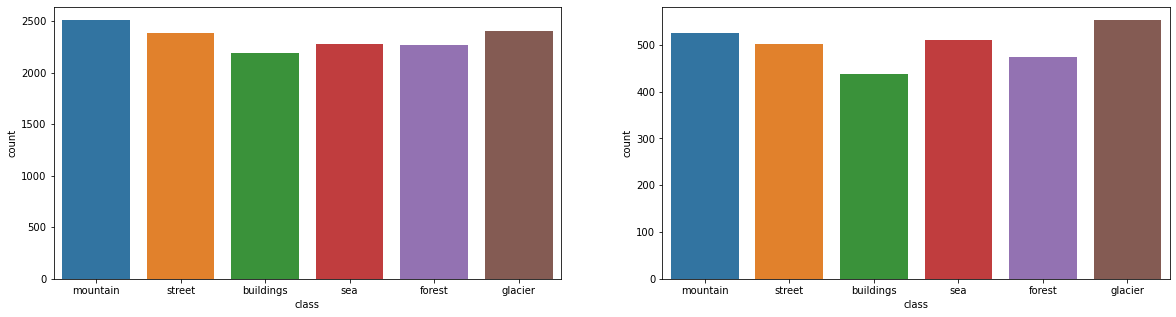

In [15]:
root_path = '/kaggle/input/intel-image-classification/'
train_pred_test_folders = os.listdir(root_path)

seg_train_folders = os.listdir(os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0])) #one more seg_train folder within
seg_pred_folders = os.listdir(os.path.join(root_path,train_pred_test_folders[1],train_pred_test_folders[1]))
seg_test_folders = os.listdir(os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2]))
quantity_tr = {} 
quantity_te = {}
for folder in seg_train_folders:
    quantity_tr[folder] = len(os.listdir(os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0],folder)))

for folder in seg_test_folders:
    quantity_te[folder] = len(os.listdir(os.path.join(root_path,train_pred_test_folders[2],train_pred_test_folders[2],folder)))
    
quantity_train = pd.DataFrame(list(quantity_tr.items()), index=range(0,len(quantity_tr)), columns=['class','count'])
quantity_test = pd.DataFrame(list(quantity_te.items()), index=range(0,len(quantity_te)), columns=['class','count'])

figure, ax = plt.subplots(1,2,figsize=(20,5))
sns.barplot(x='class',y='count',data=quantity_train,ax=ax[0])
sns.barplot(x='class',y='count',data=quantity_test,ax=ax[1])

print("Number of images in the train set : ", sum(quantity_tr.values()))
print("Number of images in the test set ; ",sum(quantity_te.values()))
number_of_images_in_prediction_set = len(os.listdir(os.path.join(root_path,train_pred_test_folders[1],train_pred_test_folders[1])))
print("Number of images in prediction set : ",number_of_images_in_prediction_set)

plt.show()

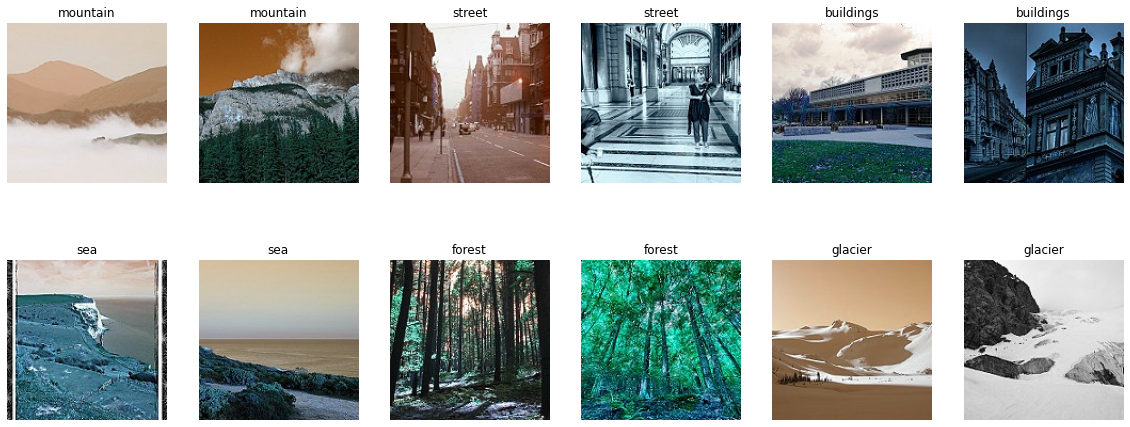

In [16]:
number_of_examples = 2
figure1, ax1 = plt.subplots(number_of_examples,len(seg_train_folders), figsize=(20,4*number_of_examples))
ax1 = ax1.reshape(-1)
axoff_fun = np.vectorize(lambda ax:ax.axis('off'))
axoff_fun(ax1)
axs = 0
for i, folder in enumerate(seg_train_folders):
    image_ids = os.listdir(os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0],folder))[0:number_of_examples]
    for j, img in enumerate(image_ids):
        img_path = os.path.join(root_path,train_pred_test_folders[0],train_pred_test_folders[0],folder,img)
        display = cv2.imread(img_path)
        plt.axis('off')
        ax1[axs].imshow(display)
        ax1[axs].set_title(folder)
        axs=axs+1

In [17]:
train_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale = 1.0/255,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

Found 14034 images belonging to 6 classes.


In [18]:
len(train_generator[0][0][0][0])


150

In [19]:
test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_DIR, batch_size=32, class_mode='categorical', target_size=(150, 150))

Found 3000 images belonging to 6 classes.


In [20]:
print(train_generator.class_indices)
inv_map_classes = {v: k for k, v in train_generator.class_indices.items()}
print(inv_map_classes)

{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
{0: 'buildings', 1: 'forest', 2: 'glacier', 3: 'mountain', 4: 'sea', 5: 'street'}


In [21]:
tf.keras.backend.clear_session()

In [22]:
#random architecture
benchmark_model = Sequential()

# Input here is 4D array (batchsize, height, width, channels) - we have already created the train_generator with batch size 32
# 32 Images of size each 150x150 with 3 color channels will be input into this layer
benchmark_model.add(Conv2D(64, kernel_size=5, activation='relu', input_shape=(150,150,3)))
#Outputs 128 * (32* Image(150x150) * 3 ) and is the input for the next filter which performs 128 more filter convolutions
# Since the kernel size is 5, we will end up with an each image being 146 pixels on each side i.e., 146x146
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))

benchmark_model.add(Conv2D(32, kernel_size=5, activation='relu'))
benchmark_model.add(MaxPooling2D(pool_size=(4,4), strides=(2,2)))

benchmark_model.add(Flatten())
benchmark_model.add(Dense(64,activation='relu'))
benchmark_model.add(Dense(6,activation='softmax'))

benchmark_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['acc'])

benchmark_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 146, 146, 64)      4864      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 72, 72, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 68, 68, 32)        51232     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 33, 33, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 34848)             0         
_________________________________________________________________
dense (Dense)                (None, 64)                2230336   
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 3

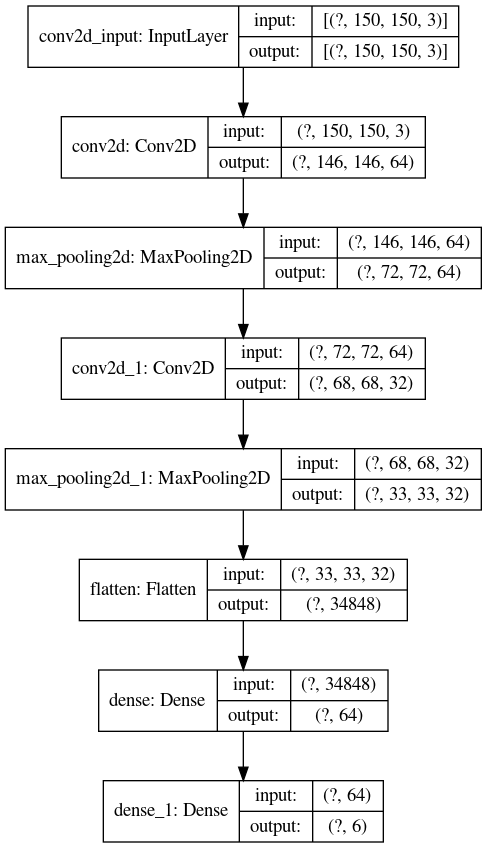

In [23]:
from keras.utils import plot_model
plot_model(benchmark_model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [24]:
filepath = "bench_mark_-model-{epoch:02d}-{val_acc:.2f}.hdf5"
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.05, patience=5, min_lr=0.000002)
checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max')
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history = benchmark_model.fit(train_generator,epochs=5, verbose=1, validation_data = validation_generator,callbacks=[reduce_lr,early_stopping,checkpoint])

#last_model = keras.models.load_model('../input/pretrained-models-on-intel-image-classification/inception_-saved-model-06-1.88.hdf5')

Epoch 1/5
439/439 [==============================] - ETA: 0s - loss: 1.1902 - acc: 0.5172
Epoch 00001: saving model to bench_mark_-model-01-0.61.hdf5
439/439 [==============================] - 108s 247ms/step - loss: 1.1902 - acc: 0.5172 - val_loss: 1.0016 - val_acc: 0.6127
Epoch 2/5
439/439 [==============================] - ETA: 0s - loss: 0.9846 - acc: 0.6178
Epoch 00002: saving model to bench_mark_-model-02-0.66.hdf5
439/439 [==============================] - 107s 243ms/step - loss: 0.9846 - acc: 0.6178 - val_loss: 0.8896 - val_acc: 0.6613
Epoch 3/5
439/439 [==============================] - ETA: 0s - loss: 0.9219 - acc: 0.6427
Epoch 00003: saving model to bench_mark_-model-03-0.70.hdf5
439/439 [==============================] - 107s 243ms/step - loss: 0.9219 - acc: 0.6427 - val_loss: 0.7595 - val_acc: 0.7033
Epoch 4/5
439/439 [==============================] - ETA: 0s - loss: 0.8663 - acc: 0.6708
Epoch 00004: saving model to bench_mark_-model-04-0.70.hdf5
439/439 [================

In [25]:
#convert the history.history dict to a pandas DataFrame:     
hist_df = pd.DataFrame(history.history) 

# save to json:  
hist_json_file = 'base_model_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = 'base_model_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)
    
benchmark_model.save(filepath)

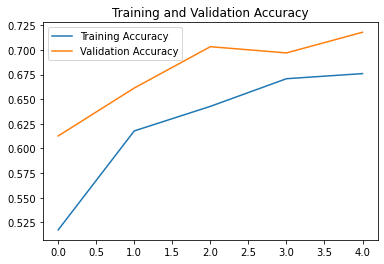

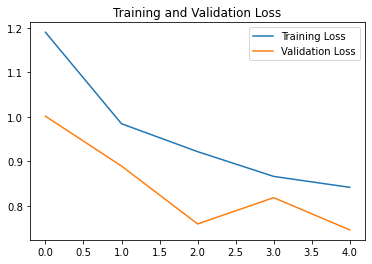

In [26]:
color = sns.color_palette()
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

sns.lineplot(epochs, acc, label='Training Accuracy')
sns.lineplot(epochs, val_acc,label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.figure()

sns.lineplot(epochs, loss,label='Training Loss')
sns.lineplot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()

In [27]:
train_DIR = "/kaggle/input/intel-image-classification/seg_train/seg_train/"

train_datagen = ImageDataGenerator( rescale = 1.0/255,width_shift_range=0.2,height_shift_range=0.2,zoom_range=0.2)

# we are rescaling by 1.0/255 to normalize the rgb values if they are in range 0-255 the values are too high for good model performance. 
train_generator = train_datagen.flow_from_directory(train_DIR,
                                                    batch_size=32,
                                                    class_mode='categorical',
                                                    target_size=(150, 150))

test_DIR = "/kaggle/input/intel-image-classification/seg_test/seg_test/"
validation_datagen = ImageDataGenerator(rescale = 1.0/255) #we are only normalising to make the prediction, the other parameters were used for agumentation and train weights
validation_generator = validation_datagen.flow_from_directory(test_DIR, batch_size=32, class_mode='categorical', target_size=(150, 150))

Found 14034 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


58892288/58889256 [==============================] - 1s 0us/step


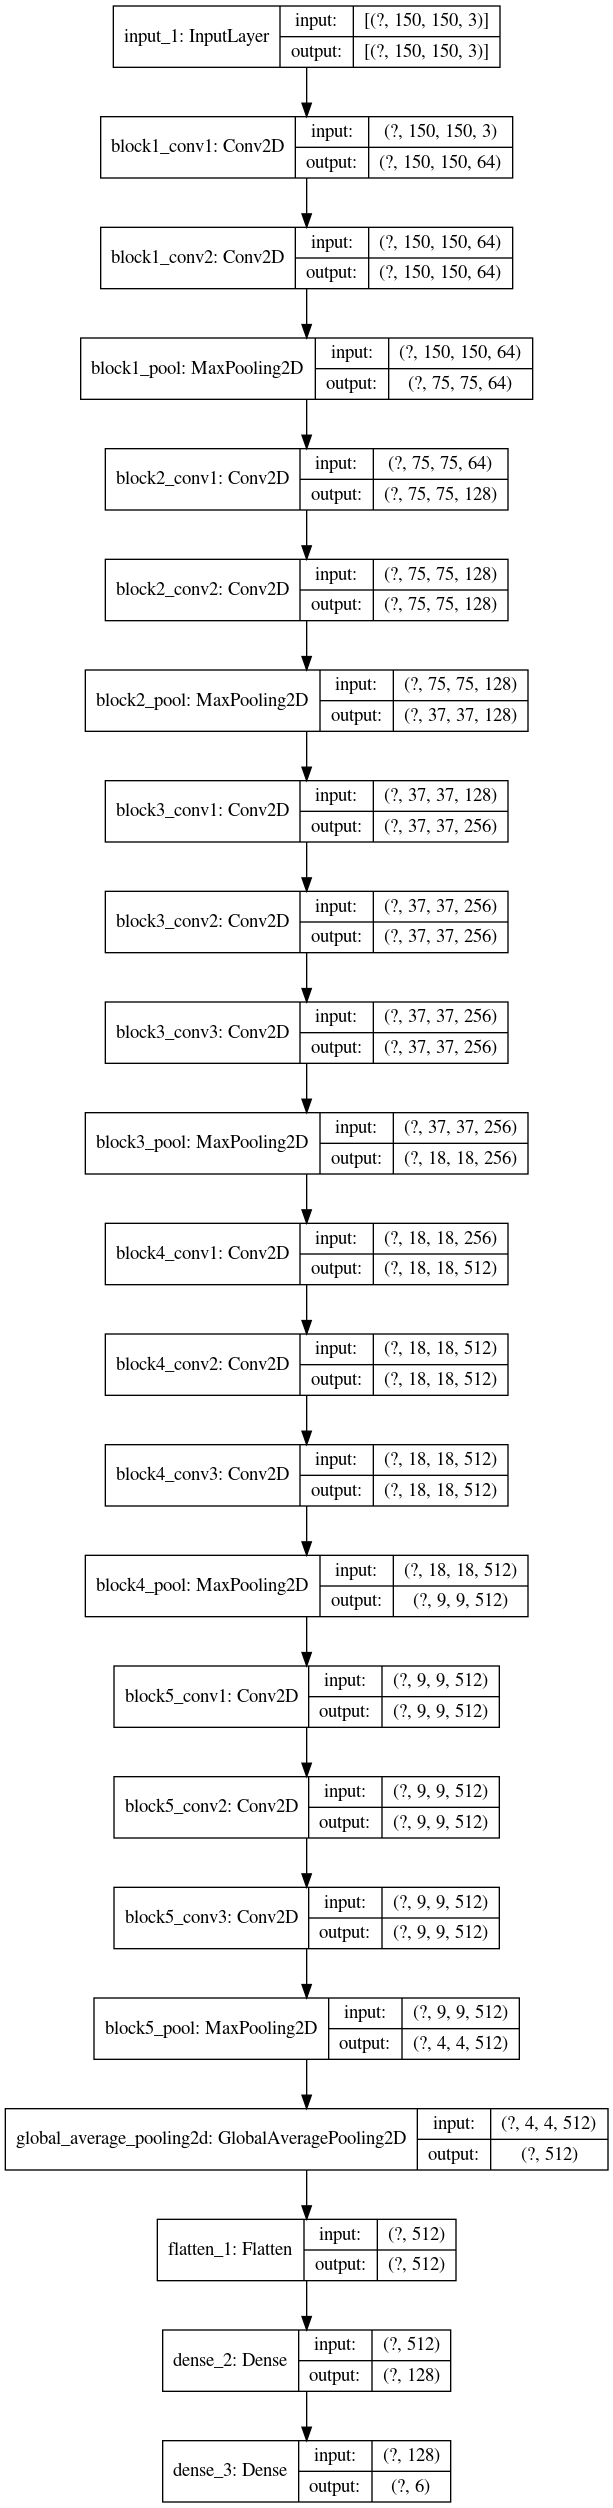

In [28]:
filepath = "vgg16_saved-model-{epoch:02d}-{val_acc:.2f}.hdf5"
vgg16_model = VGG16(pooling='avg', weights='imagenet', include_top=False, input_shape=(150,150,3))

last_output = vgg16_model.layers[-1].output
vgg_x = Flatten()(last_output)
vgg_x = Dense(128, activation = 'relu')(vgg_x)
vgg_x = Dense(6, activation = 'softmax')(vgg_x)

vgg16_final_model = Model(vgg16_model.input, vgg_x)
vgg16_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
plot_model(vgg16_final_model, to_file='model.png',show_shapes=True, show_layer_names=True)

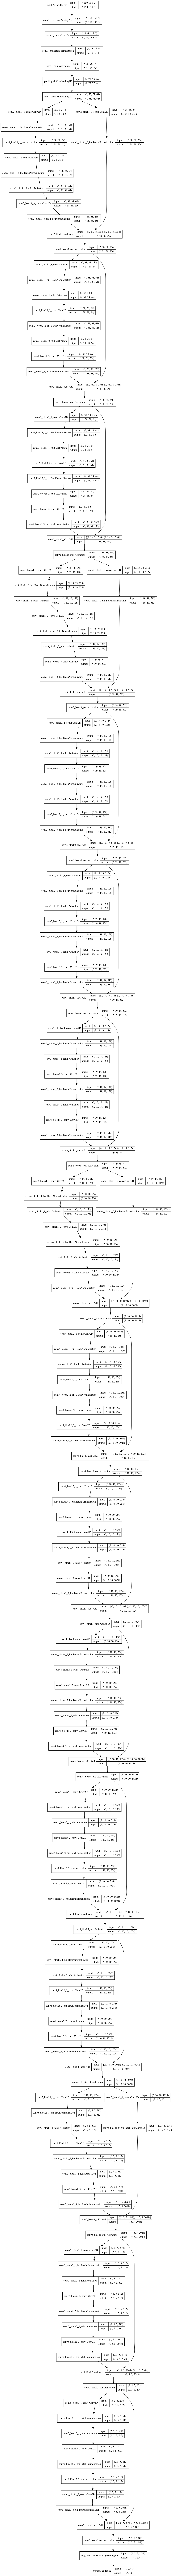

In [33]:
input_tensor = Input(shape=(150, 150, 3))
ResNet50_model = ResNet50(weights=None,classes=6, include_top=True,input_tensor=input_tensor, input_shape=(150,150,3))
res_last_output = ResNet50_model.layers[-1].output
resnet50_x = Dense(units = 128, activation = 'relu')(res_last_output)
resnet50_x = Dense(6, activation = 'softmax')(resnet50_x)

resnet50_x_final_model = Model(ResNet50_model.input, resnet50_x)
resnet50_x_final_model.compile(loss = 'categorical_crossentropy', optimizer= 'adam', metrics=['acc'])
plot_model(ResNet50_model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [30]:
# this could also be the output a different Keras model or layer
input_tensor = Input(shape=(150, 150, 3))

InceptionV3_model = InceptionV3(input_tensor=None, input_shape=(150,150,3),weights=None, include_top=True, classes=6)
InceptionV3_last_output = InceptionV3_model.layers[-1].output
InceptionV3_x = Dense(1024, activation='relu')(InceptionV3_last_output)
# and a logistic layer -- let's say we have 200 classes
InceptionV3_x = Dense(6, activation='softmax')(InceptionV3_x)
InceptionV3_x_final_model = Model(InceptionV3_model.input, InceptionV3_x)
InceptionV3_x_final_model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
plot_model(InceptionV3_x_final_model, to_file='model.png',show_shapes=True, show_layer_names=True)

In [31]:
model = []
#model.append(vgg16_final_model)
model.append(resnet50_x_final_model)
model.append(InceptionV3_x_final_model)

In [32]:
number_of_epochs = 30
models = []

vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
resnet_filepath = 'resnet50_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
inception_filepath = 'inception_'+'-saved-model-{epoch:02d}-{val_acc:.2f}.hdf5'

checkpoint = []
checkpoint.append(tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max'))
checkpoint.append(tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max'))
checkpoint.append(tf.keras.callbacks.ModelCheckpoint(inception_filepath, verbose=1, save_best_only=False, mode='max'))

vgg16_loss = []
resnet50_loss = []
inception_loss = []
model_loss = [vgg16_loss, resnet50_loss, inception_loss]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        model_loss.append([epoch, [logs[k] for k in keys]])


for i in range(len(model)):
    
    history = model[i].fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[checkpoint[i],early_stopping, CustomCallback()],verbose=1)
    models.append([model[i],history])
    
    

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.4451 - acc: 0.4216
Epoch 00001: saving model to vgg_16_-saved-model-01-acc-0.55.hdf5
439/439 [==============================] - 129s 293ms/step - loss: 1.4451 - acc: 0.4216 - val_loss: 1.0504 - val_acc: 0.5463
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.9824 - acc: 0.5889
Epoch 00002: saving model to vgg_16_-saved-model-02-acc-0.71.hdf5
439/439 [==============================] - 126s 287ms/step - loss: 0.9824 - acc: 0.5889 - val_loss: 0.8014 - val_acc: 0.7110
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.7810 - acc: 0.7036
Epoch 00003: saving model to vgg_16_-saved-model-03-acc-0.75.hdf5
439/439 [==============================] - 125s 284ms/step - loss: 0.7810 - acc: 0.7036 - val_loss: 0.7239 - val_acc: 0.7450
Epoch 4/30
439/439 [==============================] - ETA: 0s - loss: 0.6701 - acc: 0.7478
Epoch 00004: saving model to vgg_16_-saved-model-04-acc-0.81.hd

Epoch 30/30
439/439 [==============================] - ETA: 0s - loss: 0.3189 - acc: 0.8886
Epoch 00030: saving model to vgg_16_-saved-model-30-acc-0.89.hdf5
439/439 [==============================] - 120s 274ms/step - loss: 0.3189 - acc: 0.8886 - val_loss: 0.3195 - val_acc: 0.8907
Epoch 1/30


ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None) and (None, 5, 5, 6) are incompatible


In [35]:
number_of_epochs = 30
models = []

#vgg16_filepath = 'vgg_16_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
resnet_filepath = 'resnet50_'+'-saved-model-{epoch:02d}-acc-{val_acc:.2f}.hdf5'
inception_filepath = 'inception_'+'-saved-model-{epoch:02d}-{val_acc:.2f}.hdf5'

checkpoint = []
#checkpoint.append(tf.keras.callbacks.ModelCheckpoint(vgg16_filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max'))
checkpoint.append(tf.keras.callbacks.ModelCheckpoint(resnet_filepath, monitor='val_acc', verbose=1, save_best_only=False, mode='max'))
checkpoint.append(tf.keras.callbacks.ModelCheckpoint(inception_filepath, verbose=1, save_best_only=False, mode='max'))

#vgg16_loss = []
resnet50_loss = []
inception_loss = []
model_loss = [resnet50_loss, inception_loss]

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        model_loss.append([epoch, [logs[k] for k in keys]])


for i in range(len(model)):
    
    history = model[i].fit(train_generator, epochs = number_of_epochs ,validation_data = validation_generator,callbacks=[checkpoint[i],early_stopping, CustomCallback()],verbose=1)
    models.append([model[i],history])
    
    

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 0.3008 - acc: 0.8946
Epoch 00001: saving model to resnet50_-saved-model-01-acc-0.89.hdf5
439/439 [==============================] - 123s 279ms/step - loss: 0.3008 - acc: 0.8946 - val_loss: 0.3408 - val_acc: 0.8893
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 0.3166 - acc: 0.8899
Epoch 00002: saving model to resnet50_-saved-model-02-acc-0.88.hdf5
439/439 [==============================] - 120s 273ms/step - loss: 0.3166 - acc: 0.8899 - val_loss: 0.3694 - val_acc: 0.8813
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 0.2871 - acc: 0.8954
Epoch 00003: saving model to resnet50_-saved-model-03-acc-0.88.hdf5
439/439 [==============================] - 120s 272ms/step - loss: 0.2871 - acc: 0.8954 - val_loss: 0.3599 - val_acc: 0.8797
Epoch 4/30
439/439 [==============================] - ETA: 0s - loss: 0.3031 - acc: 0.8968
Epoch 00004: saving model to resnet50_-saved-model-04-acc

ValueError: in user code:

    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:806 train_function  *
        return step_function(self, iterator)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:796 step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:1211 run
        return self._extended.call_for_each_replica(fn, args=args, kwargs=kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2585 call_for_each_replica
        return self._call_for_each_replica(fn, args, kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/distribute/distribute_lib.py:2945 _call_for_each_replica
        return fn(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:789 run_step  **
        outputs = model.train_step(data)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/training.py:749 train_step
        y, y_pred, sample_weight, regularization_losses=self.losses)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/engine/compile_utils.py:204 __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:149 __call__
        losses = ag_call(y_true, y_pred)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:253 call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/losses.py:1535 categorical_crossentropy
        return K.categorical_crossentropy(y_true, y_pred, from_logits=from_logits)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/util/dispatch.py:201 wrapper
        return target(*args, **kwargs)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/keras/backend.py:4687 categorical_crossentropy
        target.shape.assert_is_compatible_with(output.shape)
    /opt/conda/lib/python3.7/site-packages/tensorflow/python/framework/tensor_shape.py:1134 assert_is_compatible_with
        raise ValueError("Shapes %s and %s are incompatible" % (self, other))

    ValueError: Shapes (None, None) and (None, 5, 5, 6) are incompatible


In [ ]:
number_of_epochs = 30
models = []
model = []
model.append(InceptionV3_x_final_model)
# models.append(last_model)
inception_filepath = 'inception_'+'-saved-model-{epoch:02d}-loss-{loss:.2f}.hdf5'

checkpoint = tf.keras.callbacks.ModelCheckpoint(inception_filepath, verbose=1, save_best_only=False, mode='max')

inception_loss = []

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

class CustomCallback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        keys = list(logs.keys())
        inception_loss.append([epoch, [logs[k] for k in keys]])


for i in range(len(model)):
    
    history = model[i].fit(train_generator, epochs = number_of_epochs, validation_data = validation_generator,callbacks=[checkpoint,early_stopping],verbose=1)
    models.append([model[i],history])
    
    

Epoch 1/30
439/439 [==============================] - ETA: 0s - loss: 1.5781
Epoch 00001: saving model to inception_-saved-model-01-loss-1.58.hdf5
439/439 [==============================] - 122s 278ms/step - loss: 1.5781 - val_loss: 1.4005
Epoch 2/30
439/439 [==============================] - ETA: 0s - loss: 1.3001
Epoch 00002: saving model to inception_-saved-model-02-loss-1.30.hdf5
439/439 [==============================] - 119s 272ms/step - loss: 1.3001 - val_loss: 1.2251
Epoch 3/30
439/439 [==============================] - ETA: 0s - loss: 1.1175
Epoch 00003: saving model to inception_-saved-model-03-loss-1.12.hdf5
439/439 [==============================] - 119s 271ms/step - loss: 1.1175 - val_loss: 1.2270
Epoch 4/30
439/439 [==============================] - ETA: 0s - loss: 0.9728
Epoch 00004: saving model to inception_-saved-model-04-loss-0.97.hdf5
439/439 [==============================] - 118s 269ms/step - loss: 0.9728 - val_loss: 1.9149
Epoch 5/30
439/439 [====================

In [ ]:
mod = models[0]
hist_df = pd.DataFrame(mod[1].history) 

# save to json:  
hist_json_file = mod[0].name+'_history.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

# or save to csv: 
hist_csv_file = mod[0].name+'_history.csv'
with open(hist_csv_file, mode='w') as f:
    hist_df.to_csv(f)

In [ ]:
history = mod[1]
color = sns.color_palette()
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

sns.lineplot(epochs, loss,label='Training Loss')
sns.lineplot(epochs, val_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.figure()
plt.show()
#just pinging .. just pinging .. just pinging .. just pinging .. just pinging ..just pipnging .. just pinging